# Energy landscape of an energy-diffusion model

In [1]:
import torch
torch.set_default_dtype(torch.float64)
from energy_model.diffusion_tools import iDDPMModelWrapper
import ase.io as aio

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
model = torch.load("/home/rokas/Programming/Generative_model_energy/test_model.model", map_location=DEVICE)
model.eval()
for param in model.parameters():
    param.requires_grad = False

We'll calculate the energy landscape for a benzene molecule.

In [4]:
from mace import data, tools
from mace.tools import torch_geometric
from ase.build import molecule
import numpy as np

In [5]:
Z_TABLE = tools.AtomicNumberTable([1, 6, 7, 8, 9])
benzene = molecule("C6H6")
config = data.Configuration(benzene.get_atomic_numbers(), benzene.positions)
atomic_data = data.AtomicData.from_config(config, z_table=Z_TABLE, cutoff=10.0)
data_loader = torch_geometric.dataloader.DataLoader(
    dataset=[atomic_data] * 200, # type: ignore
    batch_size=200,
    shuffle=True,
    drop_last=False,
)

In [6]:
deformation_scales = torch.logspace(-3,1, 200).to(DEVICE)

In [7]:
from energy_model.diffusion_tools import iDDPMLossFunction # this has a handy corruption function
from ase import Atoms
def atomic_data_to_ase(node_attrs, positions):
    elements = node_attrs.detach().cpu().numpy()
    elements = np.argmax(elements, axis=1)
    elements = [Z_TABLE.zs[z] for z in elements]
    positions = positions.detach().cpu().numpy()
    atoms = Atoms(elements, positions)
    return atoms


def batch_to_ase(batch):
    ptr = batch.ptr.detach().cpu().numpy()
    for i, j in zip(ptr[:-1], ptr[1:]):
        node_attrs = batch.node_attrs[i:j]
        positions = batch.positions[i:j]
        yield atomic_data_to_ase(node_attrs, positions)

In [8]:
results = np.empty((len(deformation_scales)), dtype=object)
batch = next(iter(data_loader)).to(DEVICE)
loss_fn = iDDPMLossFunction()
corrupted_inputs = []
for i, scale in enumerate(deformation_scales):
    sigmas = torch.ones(len(batch.batch), 1, device=DEVICE) * scale
    model_input = loss_fn._get_corrupted_input(batch, sigmas)
    model_sigmas = deformation_scales[batch.batch.to(int)][:, None]
    out = model(model_input.to_dict(), model_sigmas)
    for key, value in out.items():
        out[key] = value.detach().cpu().numpy()
    results[i] = out.copy()
    ase_atoms = list(batch_to_ase(model_input))
    corrupted_inputs.append(ase_atoms[i])

In [9]:
from scipy import ndimage
import matplotlib.pyplot as plt
# nice plot settings
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 2.5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['ytick.minor.width'] = 1.5
# plt.rcParams["text.usetex"] = True
plt.rc('font', family='serif')
plt.rc('font', size=30)

Scaling to [-44.19122223464943, 44.19122223464943]


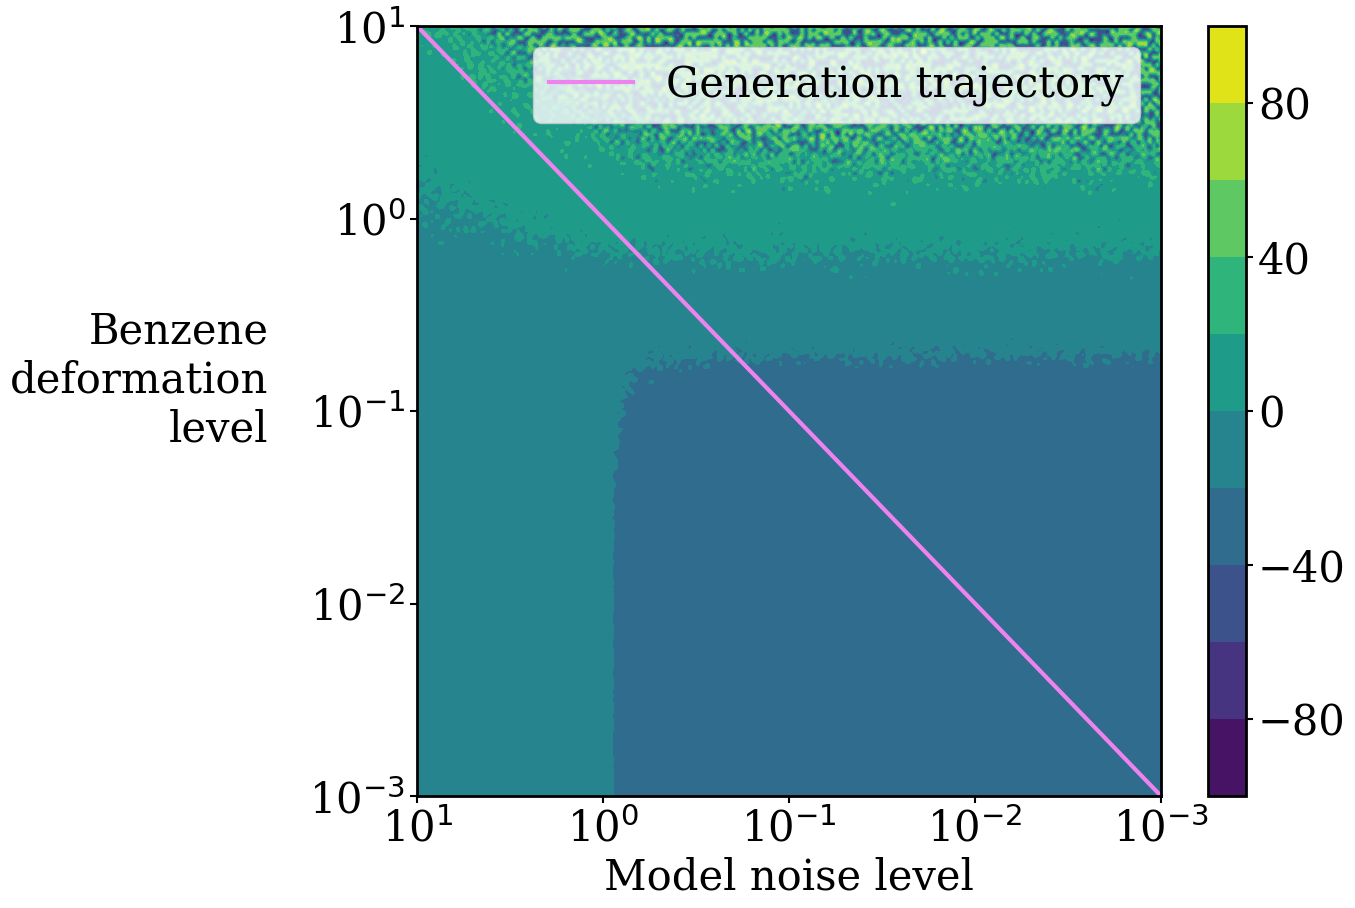

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
# Draw a contour plot to show the energy landscape of the model
energies = np.array([r["energy"] for r in results])
# remove outliers
scaled_energies = energies.copy() * -1
lower_bound = np.percentile(scaled_energies, 5)
upper_bound = np.percentile(scaled_energies, 95)
bound = np.min(np.abs([lower_bound, upper_bound]))
print(f"Scaling to [{-1*bound}, {bound}]")
scaled_energies[scaled_energies > bound] = bound
scaled_energies[scaled_energies < -1*bound] = -1*bound
smooth_scale = 3
z = ndimage.zoom(scaled_energies, smooth_scale)
x_range = deformation_scales.cpu().numpy()
log_plot_range = np.linspace(-3, 1, len(x_range)*smooth_scale)
cntr = ax.contourf(
    log_plot_range,
    log_plot_range,
    z,
    levels=10,
    # vmin=-90,
    # vmax=90,
    )
plt.colorbar(cntr, ax=ax)
tick_locks = np.array([-3, -2, -1, 0, 1])
ax.invert_xaxis()
ax.set_xticks(tick_locks)
ax.set_xticklabels([f"{10}$^{{{t}}}$" for t in tick_locks])
ax.set_yticks(tick_locks)
ax.set_yticklabels([f"{10}$^{{{t}}}$" for t in tick_locks])
ax.set_xlabel("Model noise level")
ax.set_ylabel("Benzene\ndeformation\nlevel", rotation="horizontal", horizontalalignment="right")
ax.yaxis.set_label_coords(-0.2, 0.45)
ax.plot([-3, 1], [-3, 1], color="violet", linewidth=3, label="Generation trajectory")
ax.legend()
# fig.tight_layout()
# fig.savefig("benzene_diffusion_model_energy_landscape.pdf", bbox_inches="tight")
plt.show()

In [11]:
# Generate multiple trajectories
from energy_model.diffusion_tools import HeunSampler, SamplerNoiseParameters
from moldiff.utils import initialize_mol

cutoff = 10.0
size = 12
num_samples = 10
batch_size = 1

dataset = []
mol = initialize_mol("C" * size)
config = data.Configuration(
    atomic_numbers=mol.get_atomic_numbers(),
    positions=mol.positions,
)
atomic_data = data.AtomicData.from_config(config, z_table=Z_TABLE, cutoff=cutoff)
dataset += [atomic_data] * num_samples

data_loader = torch_geometric.dataloader.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
)

In [12]:
sampler_params=SamplerNoiseParameters(
        sigma_max=5, sigma_min=1.5e-4, S_churn=10, S_min=2e-3, S_noise=1.014
    )
sampler = HeunSampler(model, sampler_noise_parameters=sampler_params, device=DEVICE)
track_trajectory = True
generated_trajectories = []
energies = []
for batch in data_loader:
        batch_data = batch.to(DEVICE)
        final, trajectory, gen_energy = sampler.generate_samples(
            batch_data, num_steps=30, training=False, track_trajectory=track_trajectory, track_energies=True
        )
        batch_data = None
        model.zero_grad()
        as_ase = [x for x in batch_to_ase(final)]
        if track_trajectory:
            as_ase = [y for x in trajectory for y in batch_to_ase(x)] + as_ase
        generated_trajectories.append(as_ase)
        energies.append(gen_energy)
        final = None

In [13]:
for atoms_list in generated_trajectories:
    aio.write("trajectory.xyz", atoms_list, append=True)

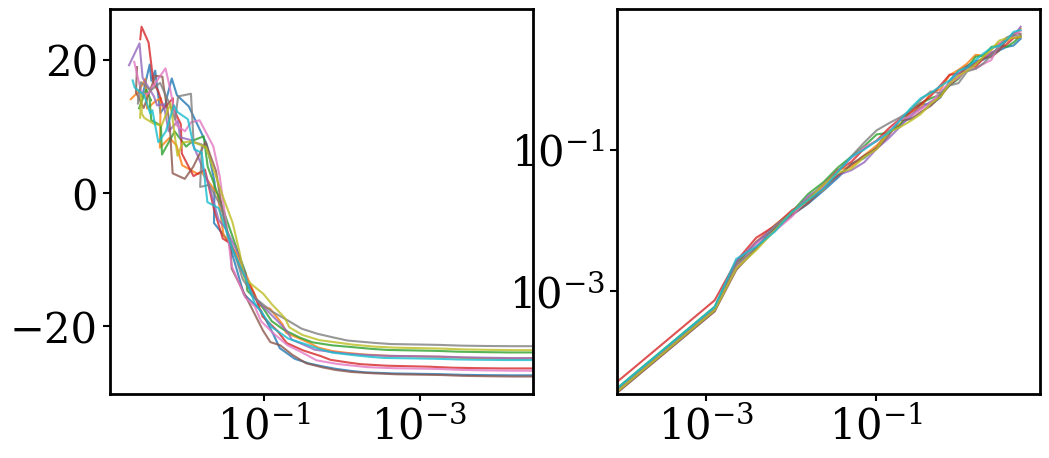

In [63]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
sampler_sigmas = sampler._get_sigma_schedule(30).detach().cpu().numpy()
for i, energy in enumerate(energies):
    x = (np.array(energy)*-1).flatten()
    traj = generated_trajectories[i]
    final_mol = traj[-1]
    var = [(a.positions - final_mol.positions).std() for a in traj]
    axes[0].plot(var, x, alpha=0.8)
    axes[1].plot(sampler_sigmas, var, alpha=0.8)
axes[0].set_xscale("log")
axes[0].invert_xaxis()
axes[1].set_xscale("log")
axes[1].set_yscale("log")
plt.show()

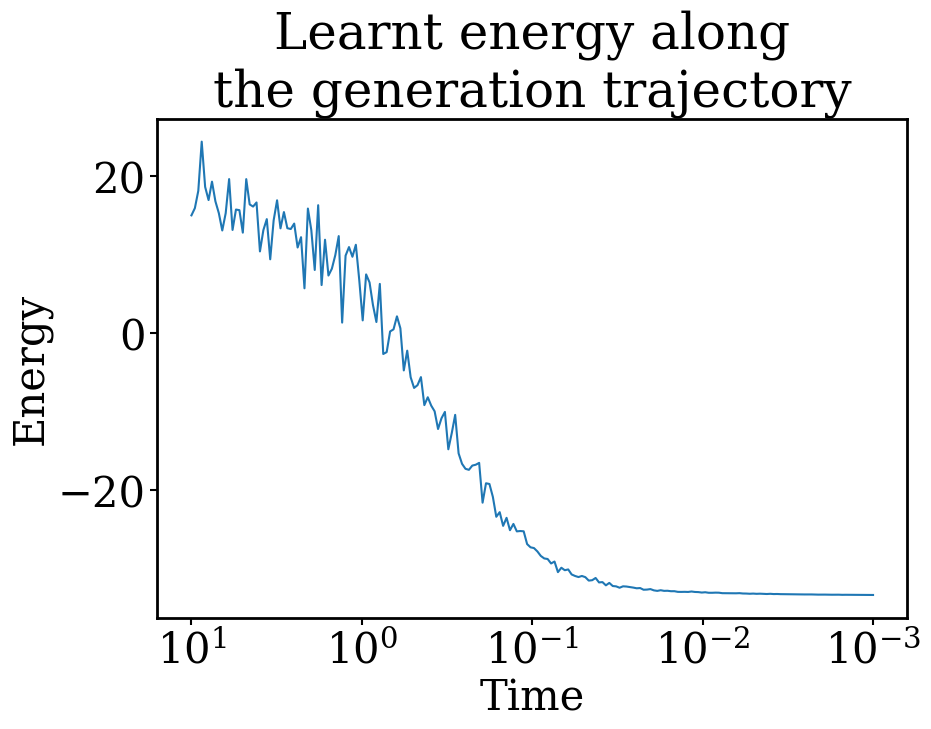

In [11]:
fig, ax = plt.subplots(figsize=(10,8))

diagonal = energies.diagonal() * -1
x_range = deformation_scales.cpu().numpy()
ax.set_title("Learnt energy along\nthe generation trajectory", pad=10)
ax.invert_xaxis()
ax.set_ylabel("Energy")
ax.set_xlabel("Time")
ax.set_xscale("log")
ax.set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.plot(x_range,diagonal)
fig.tight_layout()
# fig.savefig("benzene_diffusion_model_energy_along_trajectory.pdf", bbox_inches="tight")
plt.show()

Let's find the PM6 energy along the same generation trajectory as above.

In [13]:
corrupted_atoms = []
benzene = molecule("C6H6")
config = data.Configuration(benzene.get_atomic_numbers(), benzene.positions)
atomic_data = data.AtomicData.from_config(config, z_table=Z_TABLE, cutoff=10.0)
data_loader = torch_geometric.dataloader.DataLoader(
    dataset=[atomic_data],  # type: ignore
    batch_size=1,
    drop_last=False,
)
batch = next(iter(data_loader)).to(DEVICE)
for i, scale in enumerate(deformation_scales):
    sigmas = torch.ones(len(batch.batch), 1, device=DEVICE) * scale
    model_input = loss_fn._get_corrupted_input(batch, sigmas)
    as_atoms = [a for a in batch_to_ase(model_input)]
    corrupted_atoms.extend(as_atoms)

In [19]:
corrupted_atoms = corrupted_inputs

In [20]:
from airss_baseline.calculators import MopacCalculator

In [21]:
pm6_energies = []
for atoms in corrupted_atoms:
    atoms.set_calculator(MopacCalculator(method="PM6"))
    pm6_energies.append(atoms.get_potential_energy())

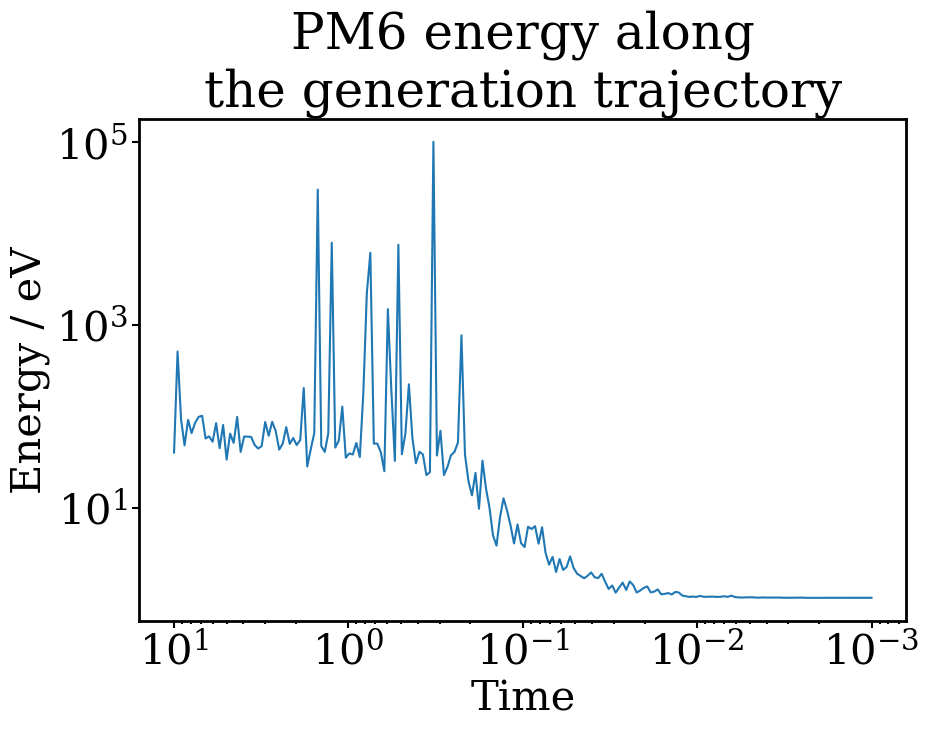

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
x_range = deformation_scales.cpu().numpy()
ax.set_title("PM6 energy along\nthe generation trajectory", pad=10)
ax.set_ylabel("Energy / eV")
ax.invert_xaxis()
ax.set_xlabel("Time")
ax.set_xscale("log")
ax.plot(x_range,pm6_energies)
ax.set_yscale("log")
fig.tight_layout()
fig.savefig("benzene_pm6_energy_along_trajectory.pdf", bbox_inches="tight")
plt.show()

In [24]:
aio.write("benzene_deformation_trajectory.xyz", corrupted_atoms, format="extxyz")

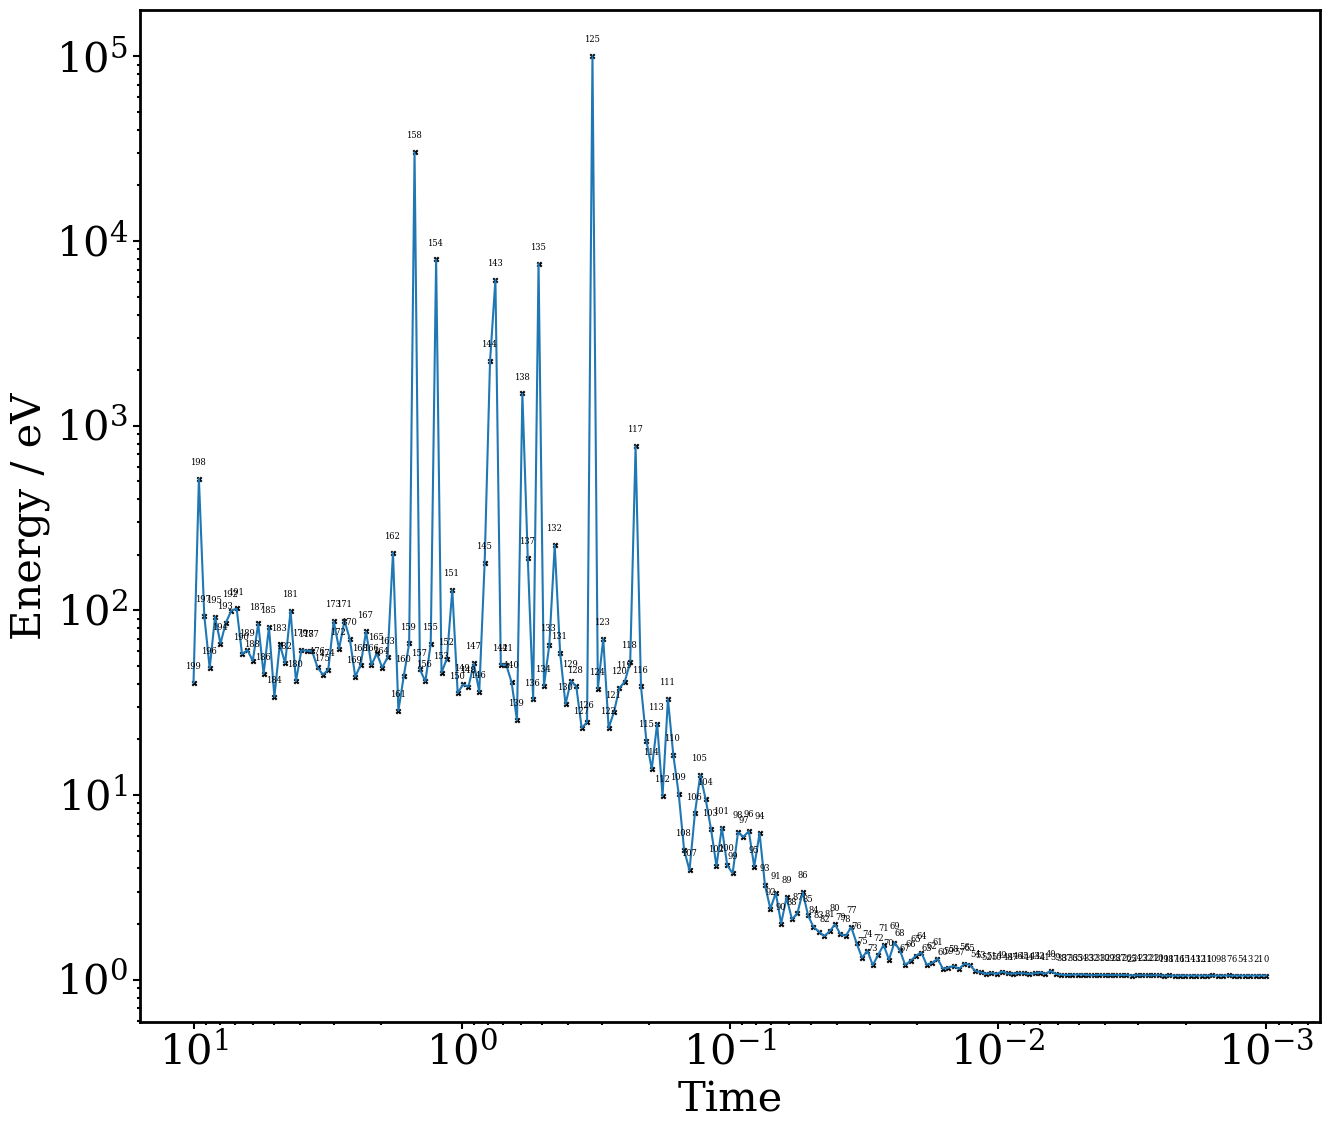

In [33]:
fig, ax = plt.subplots(figsize=(14,12))
x_range = deformation_scales.cpu().numpy()
ax.set_ylabel("Energy / eV")
ax.invert_xaxis()
ax.set_xlabel("Time")
ax.set_xscale("log")
ax.plot(x_range,pm6_energies)
ax.set_yscale("log")
scatter = ax.scatter(x_range, pm6_energies, c="black", marker="x", s=10)
for i, txt in enumerate(pm6_energies):
    ax.annotate(f"{i}", (x_range[i], pm6_energies[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=6)
fig.tight_layout()
plt.show()